In [39]:
import exif 
from PIL import Image
def visualize_image(img):
    """
    Visualize image
    """
    img = img.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    img.show()
    

def get_real_fl_fn(h,w,raw_exif):
    orig_resolution_index = {"SONY: ILCE-1":[(8640,5760)],
                             "LEICA CAMERA AG: LEICA Q2": [(8368,5584)],
                             "RICOH IMAGING COMPANY, LTD.: RICOH GR IIIx":[(6000,4000)],
                             "RICOH IMAGING COMPANY, LTD.: RICOH GR III":[(6000,4000)],
                             "Apple: iPhone 14 Pro Max":[(8064,6048),(4032,3024)],
                             "Apple: iPhone 14 Pro":[(8064,6048),(4032,3024)],
                             "Apple: iPhone 13 Pro":[(4032,3024)],
                             "Panasonic: DMC-ZS110":[(5472,3648)],
                             "Canon: Canon EOS R5":[(8192,5464)]

                            } # w,h
    if 'make' not in raw_exif:
        return
    camera_model = raw_exif['make']+": "+raw_exif["model"]
    if camera_model not in orig_resolution_index:
        raise ValueError("unknown camera model: [{}]".format(camera_model))
    long_edge_crop_ratio = max(h,w)/max(orig_resolution_index[camera_model][0])
    # iPhone special processing
    if long_edge_crop_ratio<0.5 and camera_model == "Apple: iPhone 14 Pro Max":
        long_edge_crop_ratio = max(h,w)/max(orig_resolution_index[camera_model][1])
        
    # calc real eq focal len
    # pprint(raw_exif)
    # ff camera use true fl
    if camera_model in ["LEICA CAMERA AG: LEICA Q2","SONY: ILCE-1","Canon: Canon EOS R5"]:
        uncropped_fl = raw_exif["focal_length"]
    else:
        uncropped_fl = raw_exif["focal_length_in_35mm_film"]
    

    
    real_fl = uncropped_fl/long_edge_crop_ratio
    long_edge_fn_ratio = real_fl/raw_exif["focal_length"]
    real_fn = raw_exif['f_number']*long_edge_fn_ratio

    # sony apsc lens
    if 'lens_model' not in raw_exif:
        raw_exif['lens_model'] = camera_model
    return {"camera": camera_model,
            "lens":raw_exif['lens_model'],
            "orig_fl":uncropped_fl,
            "real_fl":real_fl,
            "orig_fn": raw_exif['f_number'],
            "real_fn": real_fn,
            "long_edge_crop_ratio":long_edge_crop_ratio,
            "long_edge_fn_ratio":long_edge_fn_ratio,
            "exposure":raw_exif['exposure_time']
           }


    

    
    

In [40]:
# TODO
# Enhanced
from glob import glob 
from os.path import join
from pprint import pprint
import cv2
from tqdm import tqdm
from os.path import basename, expanduser, exists
import os
import datetime as dt
import json

img_path = '/Users/htplex/Desktop/2022-3s-processed/thumbnails/'
exif_path = '/Users/htplex/Desktop/2022-3s-processed/all_raw_exif.json'

# img_path = '/Users/htplex/Desktop/123s/thumbnails/'
# exif_path = '/Users/htplex/Desktop/123s/all_raw_exif.json'

img_path = '/Users/htplex/Desktop/ql_12345/thumbnails/'
exif_path = '/Users/htplex/Desktop/ql_12345/all_raw_exif.json'

all_exif = []
with open(exif_path, 'r') as fp:
    all_exif = json.load(fp)

# calc better exif & save to local
all_better_exif = []
for raw_exif in tqdm(all_exif.values()):
    # load exif and h,w, use precalc if using betterexif folder instead of original
    h,w = raw_exif['orig_size']
    img_fname = raw_exif['filename']
    # init better exif
    # step1: real_eq
    better_exif = get_real_fl_fn(h,w,raw_exif)
    if not better_exif:
        continue
    # add filename
    better_exif['filename'] = img_fname
    better_exif['orig_size'] = (h,w)
    better_exif["capture_time"] = raw_exif["datetime_original"]
    capture_date = dt.datetime.strptime(raw_exif["datetime_original"],
                                                      '%Y:%m:%d %H:%M:%S').date()
    better_exif["date_number"] = (capture_date-dt.date(2022,1,1)).days
    capture_time = dt.datetime.strptime(raw_exif["datetime_original"],
                                                  '%Y:%m:%d %H:%M:%S').time()
    better_exif["time_number"] = (3600*capture_time.hour+60*capture_time.minute+capture_time.second)/3600
    
    all_better_exif.append(better_exif)
    # print(better_exif)
    # print(capture_date)
    # if better_exif['orig_fl'] < 24:
    #     print(img_fname)
    

    # break
        
        

100%|██████████████████████████████████████| 186/186 [00:00<00:00, 63956.43it/s]


{'camera': 'Canon: Canon EOS R5',
 'capture_time': '2022:05:11 18:35:11',
 'date_number': 130,
 'exposure': 0.02,
 'filename': '168A0220.jpg',
 'lens': 'RF24-105mm F4 L IS USM',
 'long_edge_crop_ratio': 1.0,
 'long_edge_fn_ratio': 1.0,
 'orig_fl': 105.0,
 'orig_fn': 4.0,
 'orig_size': (4726, 8192),
 'real_fl': 105.0,
 'real_fn': 4.0,
 'time_number': 18.586388888888887}



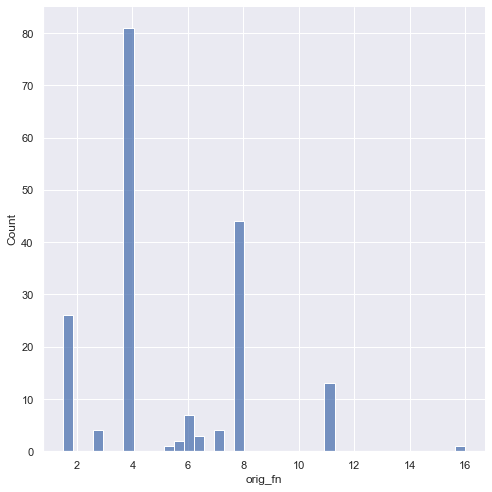

<Figure size 432x288 with 0 Axes>

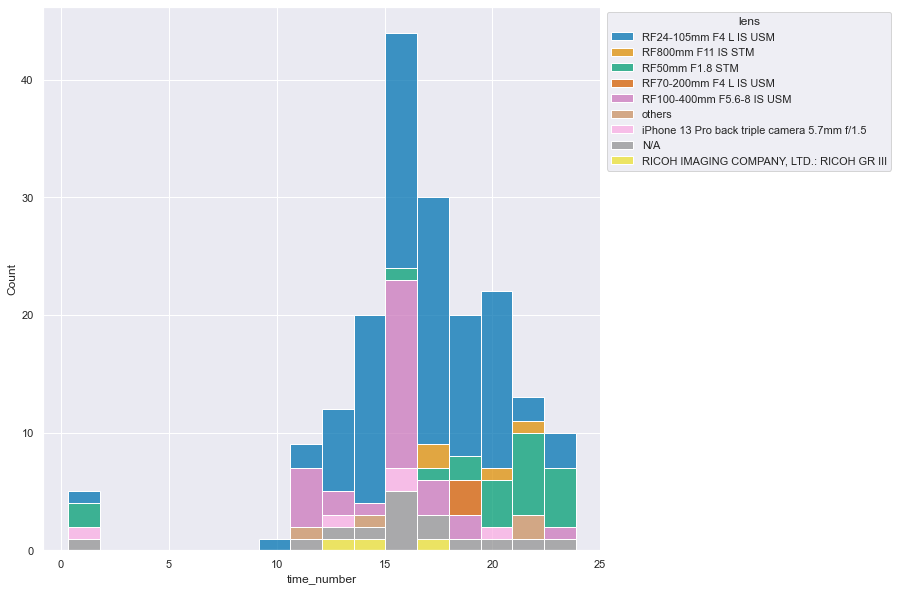

<Figure size 432x288 with 0 Axes>

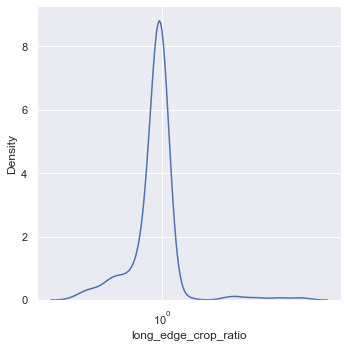

12-23: 1.61%, 3/186
14-35: 13.44%, 25/186
16-35: 12.37%, 23/186
24-70: 39.78%, 74/186
24-105: 59.14%, 110/186
28-75: 37.1%, 69/186
35-150: 61.83%, 115/186
70-200: 38.71%, 72/186
100-400: 33.87%, 63/186
100-500: 39.78%, 74/186
200-600: 18.82%, 35/186


<Figure size 432x288 with 0 Axes>

In [41]:
# data play around
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors as mcolors
pprint(all_better_exif[0])
print()
all_better_exif_df = pd.DataFrame(all_better_exif)
n_imgs = len(all_better_exif_df)


# focal length
middle_fl_df = all_better_exif_df[all_better_exif_df['real_fl'].between(0, 2000)]

sns.set_theme(style="darkgrid")
# sns.set_theme(style="whitegrid")

sns.displot(middle_fl_df,x="orig_fn",log_scale=False,bins=40,height=7)#,hue="lens")
# sns.displot(middle_fl_df,x="orig_fn",discrete=True)
# sns.displot(middle_fl_df,x="real_fl")#,hue="lens")
plt.show()
plt.clf()



# lens by time
# replace rare ones to others
fig,ax = plt.subplots(figsize=(10, 10))
lens_df = all_better_exif_df
lens_df.loc[lens_df['lens'].value_counts()[lens_df['lens']].values < 3, 'lens'] = "others"
sns.histplot(data=lens_df, x="time_number",palette="colorblind", hue="lens", multiple="stack",ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()
plt.clf()


# cropping ratio
sns.displot(middle_fl_df,kind='kde',x="long_edge_crop_ratio",log_scale=True,)#,hue="lens")

plt.show()
plt.clf()

lenses = [[12,23],[14,35],[16,35],[24,70],[24,105],[28,75],[35,150],[70,200],[100,400],[100,500],[200,600]]
max_crop_factor = 1.0
for lens in lenses:
    n_lens_covered_imgs = len(all_better_exif_df[all_better_exif_df['real_fl'].between(lens[0], lens[1]*max_crop_factor)])
    print("{}-{}: {}%, {}/{}".format(lens[0],lens[1],
                                np.around(n_lens_covered_imgs/n_imgs*100,2),
                                n_lens_covered_imgs,n_imgs))




In [44]:
# cv play around
import numpy as np
import cv2
from os.path import join
from tqdm import tqdm
import skimage.measure
def smart_compress(img,h=512):
    visualize_image(img)
    # print(vert_line.shape)
    
    for i in range(3):
        reduced_img = []
        for c in range(3):
            reduced_img.append([skimage.measure.block_reduce(img[:,:,c], (3,3), np.median)])
        reduced_img = np.concatenate(reduced_img,axis=0)
        reduced_img = reduced_img.transpose(1,2,0)
        print(reduced_img.shape)
        img = reduced_img
        visualize_image(img)

    
    

all_better_exif = sorted(all_better_exif,key=lambda x: x['capture_time'])
folder_path = img_path

for x_idx,better_exif in enumerate(tqdm(all_better_exif[32:])):
    img = cv2.imread(join(folder_path,better_exif['filename']))
    if len(img.shape)<3:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    smart_compress(img)
    break


    

  0%|                                                   | 0/154 [00:00<?, ?it/s]

(171, 253, 3)
(57, 85, 3)
(19, 29, 3)


In [36]:
# cv play around
import numpy as np
import cv2
from os.path import join
from tqdm import tqdm
def get_img_y_color(img,h=512):
    visualize_image(img)
    h,w = img.shape[:2]
    img = cv2.resize(img,(int(512/h*w),512))
    
    vert_line = np.mean(img,axis=1)
    # print(vert_line.shape)
    return vert_line
    
    

all_better_exif = sorted(all_better_exif,key=lambda x: x['capture_time'])
folder_path = img_path
vert_line_canvas = np.zeros((512,len(all_better_exif),3))
vert_lines = []
for x_idx,better_exif in enumerate(tqdm(all_better_exif)):
    img = cv2.imread(join(folder_path,better_exif['filename']))
    if len(img.shape)<3:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    # vert_line_canvas[:,x_idx,:] = get_img_y_color(img)
    vert_lines.append(get_img_y_color(img))
vert_lines = sorted(vert_lines,key = lambda x: np.average(x))

for x_idx,vert_line in enumerate(vert_lines):
    vert_line_canvas[:,x_idx,:] = vert_line
    
    
    # break
# vert_line_canvas = cv2.resize(vert_line_canvas,(512,512))
visualize_image(vert_line_canvas)
# print(all_better_exif[0])
    

100%|█████████████████████████████████████████| 717/717 [00:08<00:00, 81.63it/s]
